In [1]:
import pandas as pd
import os

# Get all files from the /merged directory training data 
merged_dir = 'traindata'
all_files = []

# Walk through the directory to find all files
for root, dirs, files in os.walk(merged_dir):
    for file in files:
        if file.endswith(('.csv', '.parquet', '.json', '.xlsx')):  # Add other file types as needed
            all_files.append(os.path.join(root, file))

# Load and concatenate all files into a single dataframe
dfs = []
for file_path in all_files:
    try:
        if file_path.endswith('.csv'):
            temp_df = pd.read_csv(file_path)
            if len(dfs) >= 15:  # Only load first 15 files
                break
       
        
        dfs.append(temp_df)
        print(f"Loaded: {file_path}")
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

# Concatenate all dataframes
if dfs:
    train = pd.concat(dfs, ignore_index=True)
    print(f"Successfully loaded {len(dfs)} files into dataframe")
else:
    print("No files found or loaded")

Loaded: traindata/merged_2013-11-19.csv
Loaded: traindata/merged_2013-12-06.csv
Loaded: traindata/merged_2013-11-18.csv
Loaded: traindata/merged_2013-11-22.csv
Loaded: traindata/merged_2013-12-02.csv
Loaded: traindata/merged_2013-11-10.csv
Loaded: traindata/merged_2013-11-03.csv
Loaded: traindata/merged_2013-11-21.csv
Loaded: traindata/merged_2013-11-07.csv
Loaded: traindata/merged_2013-12-13.csv
Loaded: traindata/merged_2013-11-12.csv
Loaded: traindata/merged_2013-11-02.csv
Loaded: traindata/merged_2013-11-09.csv
Loaded: traindata/merged_2013-11-01.csv
Loaded: traindata/merged_2013-11-05.csv
Successfully loaded 15 files into dataframe


In [2]:
print(train.head)

# Convert Time Interval column to datetime first
train['Time Interval (GMT+1)'] = pd.to_datetime(train['Time Interval (GMT+1)'])

# Split the Time Interval column into separate date and time components
train['Date'] = train['Time Interval (GMT+1)'].dt.date
train['Time_Numeric'] = train['Time Interval (GMT+1)'].dt.hour + train['Time Interval (GMT+1)'].dt.minute/60

print("Time interval split completed!")
print(f"Date column sample: {train['Date'].head()}")
print(f"Time_Numeric column sample: {train['Time_Numeric'].head()}")
print(f"Data types - Date: {train['Date'].dtype}, Time_Numeric: {train['Time_Numeric'].dtype}")

<bound method NDFrame.head of          Milan_Grid_Square_ID      Time Interval (GMT+1)  \
0                        2526  2013-11-19 00:00:00+01:00   
1                        2526  2013-11-19 00:10:00+01:00   
2                        2526  2013-11-19 00:20:00+01:00   
3                        2526  2013-11-19 00:30:00+01:00   
4                        2526  2013-11-19 00:40:00+01:00   
...                       ...                        ...   
4880519                  7475  2013-11-05 23:10:00+01:00   
4880520                  7475  2013-11-05 23:20:00+01:00   
4880521                  7475  2013-11-05 23:30:00+01:00   
4880522                  7475  2013-11-05 23:40:00+01:00   
4880523                  7475  2013-11-05 23:50:00+01:00   

         Internet traffic activity  SMS activity  Call activity  is_day_off  \
0                         7.569519      0.192982       0.129232           0   
1                         7.468271      1.109266       0.345474           0   
2           

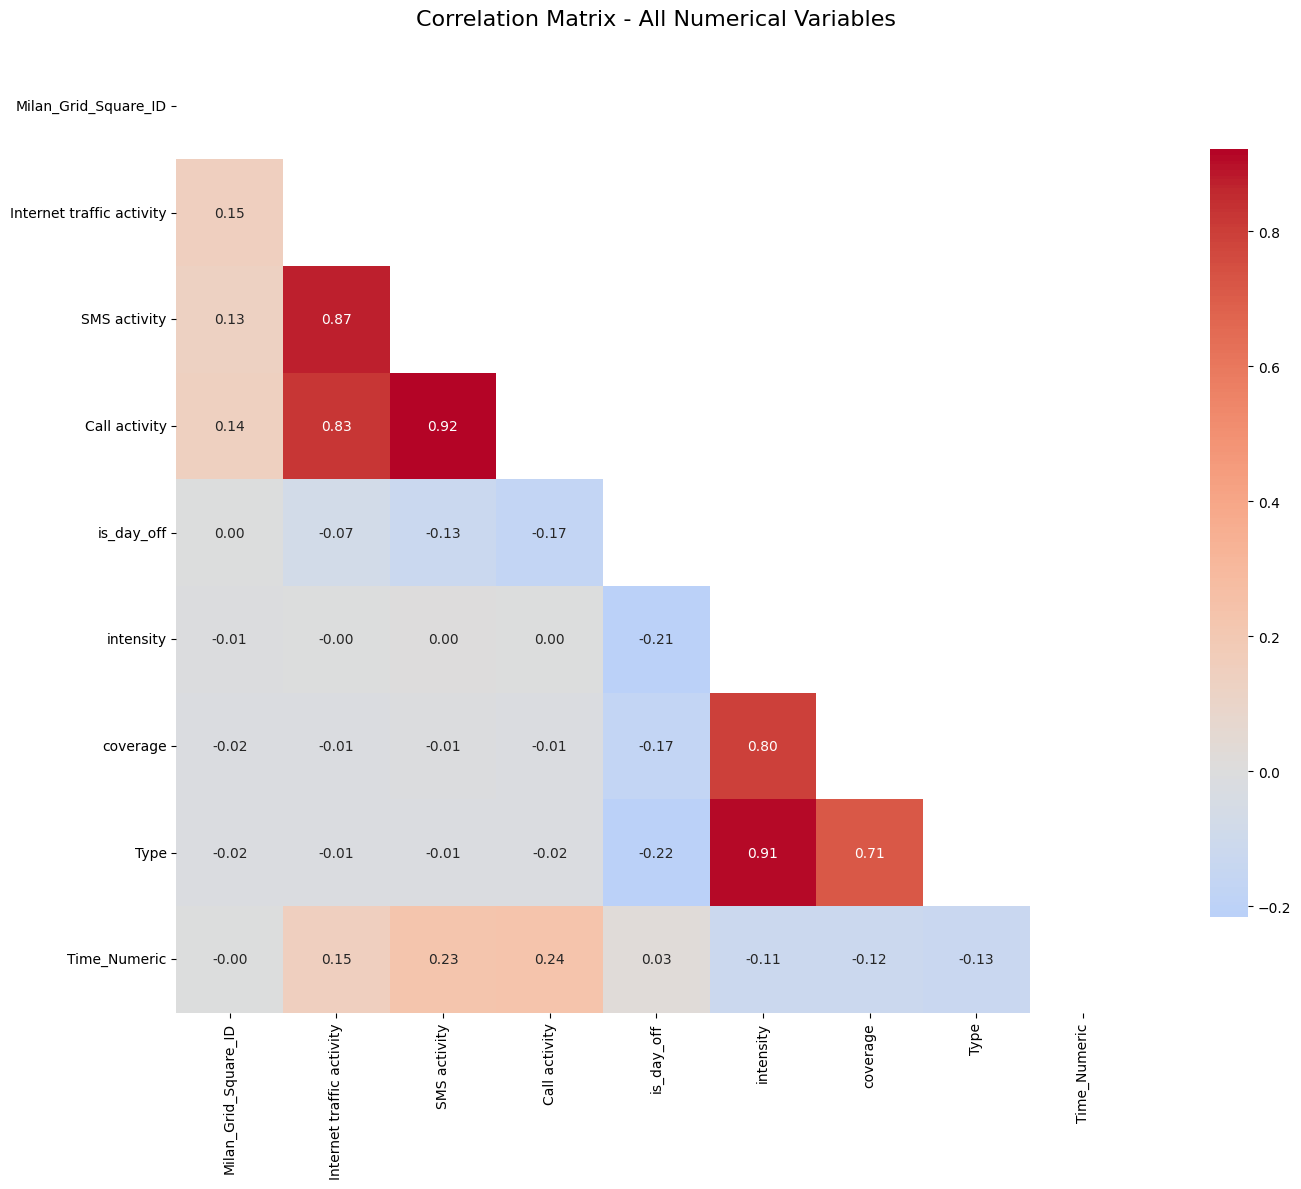

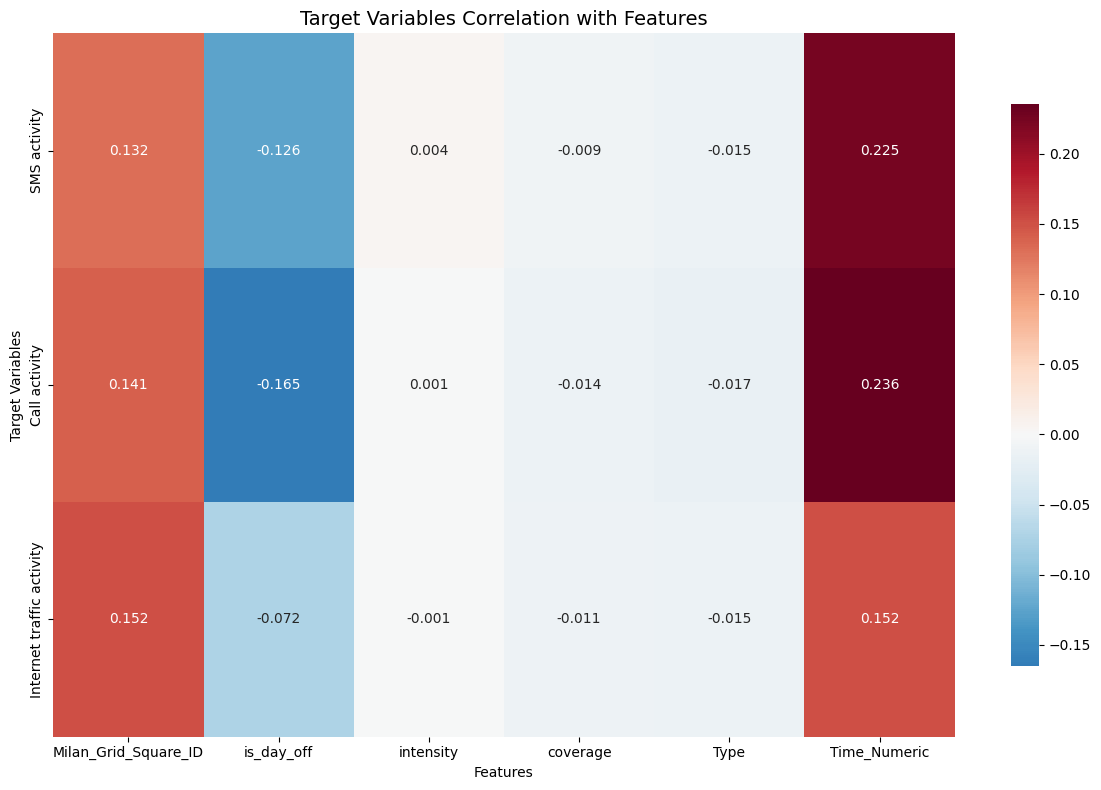

Correlation matrix created successfully!
Matrix shape: (9, 9)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define numerical columns that exist in the dataframe
numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()

# Create correlation matrix for all numerical variables
correlation_matrix = train[numerical_cols].corr()
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
            mask=mask, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8})
plt.title('Correlation Matrix - All Numerical Variables', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Define target variables
target_vars = ['SMS activity', 'Call activity', 'Internet traffic activity']

# Focus on target variables correlation with other features
target_correlation = correlation_matrix[target_vars].drop(target_vars, axis=0)
plt.figure(figsize=(12, 8))
sns.heatmap(target_correlation.T, 
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            fmt='.3f',
            cbar_kws={"shrink": .8})
plt.title('Target Variables Correlation with Features', fontsize=14)
plt.ylabel('Target Variables')
plt.xlabel('Features')
plt.tight_layout()
plt.show()

print("Correlation matrix created successfully!")
print(f"Matrix shape: {correlation_matrix.shape}")


In [4]:
%load_ext cuml.accel
# Comprehensive Data Transformation Pipeline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
import seaborn as sns

def comprehensive_data_transformation(df):
    """
    Apply comprehensive transformations to improve model performance
    """
    data = df.copy()
    
    # 1. TEMPORAL FEATURE ENGINEERING
    print("1. Creating temporal features...")
    
    # Convert time to cyclical features (important for time patterns)
    data['hour_sin'] = np.sin(2 * np.pi * data['Time_Numeric'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['Time_Numeric'] / 24)
    
    # Create time-based bins
    data['time_period'] = pd.cut(data['Time_Numeric'], 
                               bins=[0, 6, 12, 18, 24], 
                               labels=['Night', 'Morning', 'Afternoon', 'Evening'])
    
    # Day of week features (if date available)
    if 'Date' in data.columns:
        data['Date'] = pd.to_datetime(data['Date'])
        data['day_of_week'] = data['Date'].dt.dayofweek
        data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)
        data['day_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
        data['day_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)
    
    # 2. GRID SQUARE FEATURE ENGINEERING
    print("2. Engineering Grid Square features...")
    
    # Instead of one-hot encoding, create meaningful features from Grid ID
    # Grid density features
    grid_counts = data['Milan_Grid_Square_ID'].value_counts()
    data['grid_density'] = data['Milan_Grid_Square_ID'].map(grid_counts)
    
    # Grid-based aggregated features (mean activity by grid)
    for target in ['SMS activity', 'Call activity', 'Internet traffic activity']:
        grid_mean = data.groupby('Milan_Grid_Square_ID')[target].mean()
        data[f'grid_avg_{target.split()[0].lower()}'] = data['Milan_Grid_Square_ID'].map(grid_mean)
    
    # Grid coordinates (if grid follows spatial pattern)
    # Assuming grid IDs have spatial meaning - extract coordinates
    data['grid_x'] = data['Milan_Grid_Square_ID'] % 100  # Extract x coordinate
    data['grid_y'] = data['Milan_Grid_Square_ID'] // 100  # Extract y coordinate
    
    # 3. TARGET VARIABLE TRANSFORMATIONS
    print("3. Transforming target variables...")
    
    target_vars = ['SMS activity', 'Call activity', 'Internet traffic activity']
    transformed_targets = {}
    
    for target in target_vars:
        # Check distribution and apply appropriate transformation
        skewness = data[target].skew()
        print(f"{target} skewness: {skewness:.3f}")
        
        if abs(skewness) > 1:  # Highly skewed
            # Try log transformation (add 1 to handle zeros)
            data[f'{target}_log'] = np.log1p(data[target])
            
            # Try Box-Cox transformation
            pt = PowerTransformer(method='box-cox', standardize=False)
            # Box-Cox requires positive values
            if data[target].min() > 0:
                data[f'{target}_boxcox'] = pt.fit_transform(data[[target]]).flatten()
            
            # Try sqrt transformation
            data[f'{target}_sqrt'] = np.sqrt(data[target])
            
            transformed_targets[target] = f'{target}_log'  # Use log as default
        else:
            transformed_targets[target] = target  # No transformation needed
    
    # 4. INTERACTION FEATURES
    print("4. Creating interaction features...")
    
    # Time-based interactions
    data['time_dayoff_interaction'] = data['Time_Numeric'] * data['is_day_off']
    data['grid_time_interaction'] = data['grid_density'] * data['Time_Numeric']
    
    # Activity correlations (targets are highly correlated)
    data['sms_call_ratio'] = data['SMS activity'] / (data['Call activity'] + 1)
    data['internet_total_ratio'] = data['Internet traffic activity'] / (
        data['SMS activity'] + data['Call activity'] + data['Internet traffic activity'] + 1)
    
    # 5. FEATURE SCALING AND SELECTION
    print("5. Preparing final feature set...")
    
    # Select features for modeling
    feature_cols = [
        # Original features
        'Milan_Grid_Square_ID', 'Time_Numeric', 'is_day_off',
        
        # Temporal features
        'hour_sin', 'hour_cos',
        
        # Grid features
        'grid_density', 'grid_x', 'grid_y',
        
        # Interaction features
        'time_dayoff_interaction', 'grid_time_interaction',
        'sms_call_ratio', 'internet_total_ratio'
    ]
    
    # Add day features if available
    if 'day_sin' in data.columns:
        feature_cols.extend(['day_sin', 'day_cos', 'is_weekend'])
    
    # Add time period dummies
    if 'time_period' in data.columns:
        time_dummies = pd.get_dummies(data['time_period'], prefix='time')
        data = pd.concat([data, time_dummies], axis=1)
        feature_cols.extend(time_dummies.columns)
    
    # Add grid average features
    grid_avg_cols = [col for col in data.columns if col.startswith('grid_avg_')]
    feature_cols.extend(grid_avg_cols)
    
    # Remove any columns that don't exist
    feature_cols = [col for col in feature_cols if col in data.columns]
    
    print(f"Final feature set: {len(feature_cols)} features")
    print(f"Features: {feature_cols}")
    
    return data, feature_cols, transformed_targets

cuML: Accelerator installed.


1. Creating temporal features...
2. Engineering Grid Square features...
3. Transforming target variables...
SMS activity skewness: 4.952
Call activity skewness: 4.413
Internet traffic activity skewness: 4.081
4. Creating interaction features...
5. Preparing final feature set...
Final feature set: 22 features
Features: ['Milan_Grid_Square_ID', 'Time_Numeric', 'is_day_off', 'hour_sin', 'hour_cos', 'grid_density', 'grid_x', 'grid_y', 'time_dayoff_interaction', 'grid_time_interaction', 'sms_call_ratio', 'internet_total_ratio', 'day_sin', 'day_cos', 'is_weekend', 'time_Night', 'time_Morning', 'time_Afternoon', 'time_Evening', 'grid_avg_sms', 'grid_avg_call', 'grid_avg_internet']


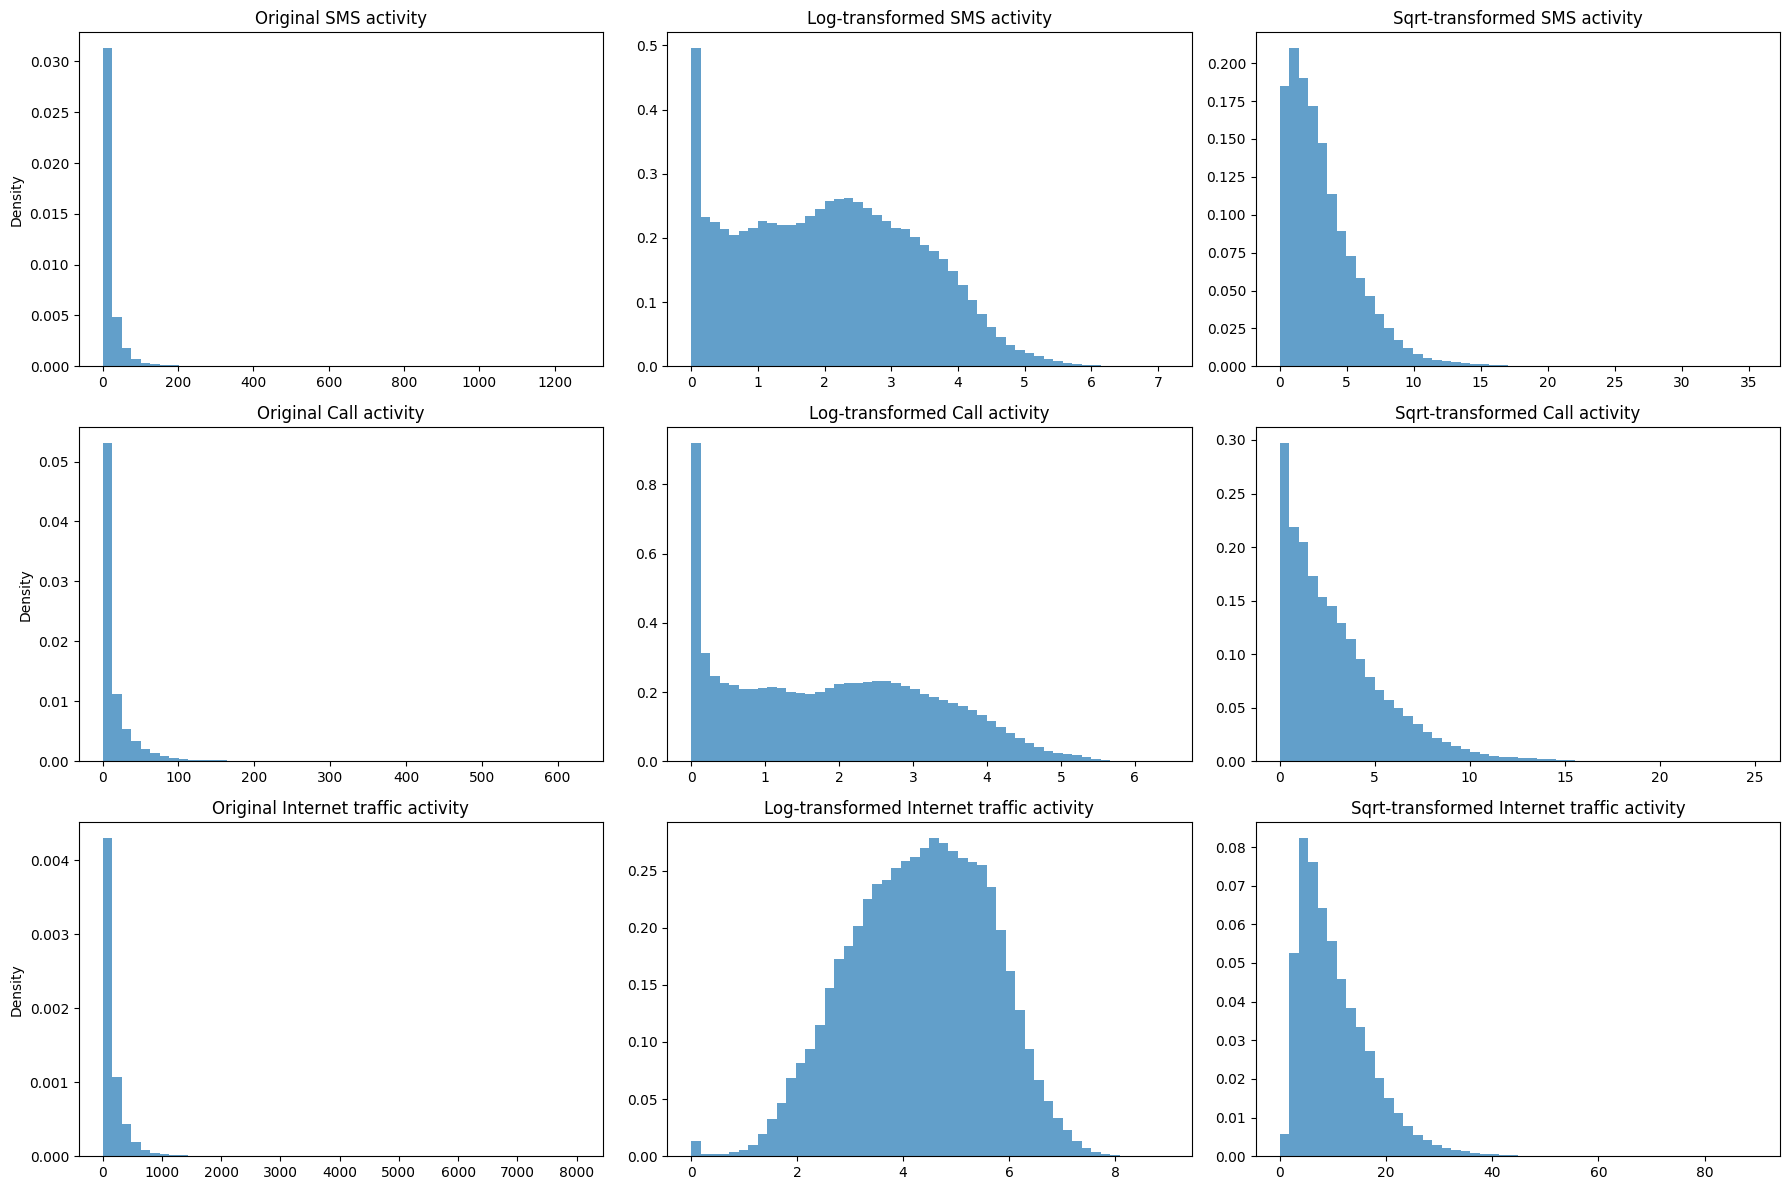

Training model with transformed features...
Unused keyword parameter: ccp_alpha during cuML estimator initialization
Unused keyword parameter: monotonic_cst during cuML estimator initialization


/home/sutol/miniconda3/lib/python3.13/site-packages/cuml/internals/api_decorators.py:320: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return init_func(self, *args, **kwargs)
/home/sutol/miniconda3/lib/python3.13/site-packages/cuml/internals/api_decorators.py:320: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return init_func(self, *args, **kwargs)
/home/sutol/miniconda3/lib/python3.13/site-packages/cuml/internals/api_decorators.py:320: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return init_func(self, *args, **kwargs)



Transformed Model Results:

SMS activity:
  MSE: 0.0398
  RMSE: 0.1995
  R2: 0.9770

Call activity:
  MSE: 0.0545
  RMSE: 0.2334
  R2: 0.9713

Internet traffic activity:
  MSE: 0.0481
  RMSE: 0.2192
  R2: 0.9715


In [5]:


# Apply transformations
transformed_data, final_features, target_transformations = comprehensive_data_transformation(train)

# Visualize transformation effects
def plot_transformation_effects(original_data, transformed_data, target_vars):
    """Plot before/after distributions"""
    
    fig, axes = plt.subplots(len(target_vars), 3, figsize=(18, 12))
    
    for i, target in enumerate(target_vars):
        # Original distribution
        axes[i, 0].hist(original_data[target], bins=50, alpha=0.7, density=True)
        axes[i, 0].set_title(f'Original {target}')
        axes[i, 0].set_ylabel('Density')
        
        # Log transformed
        if f'{target}_log' in transformed_data.columns:
            axes[i, 1].hist(transformed_data[f'{target}_log'], bins=50, alpha=0.7, density=True)
            axes[i, 1].set_title(f'Log-transformed {target}')
        
        # Box-Cox transformed (if available)
        if f'{target}_boxcox' in transformed_data.columns:
            axes[i, 2].hist(transformed_data[f'{target}_boxcox'], bins=50, alpha=0.7, density=True)
            axes[i, 2].set_title(f'Box-Cox {target}')
        else:
            axes[i, 2].hist(transformed_data[f'{target}_sqrt'], bins=50, alpha=0.7, density=True)
            axes[i, 2].set_title(f'Sqrt-transformed {target}')
    
    plt.tight_layout()
    plt.show()

# Visualize transformations
plot_transformation_effects(train, transformed_data, target_vars)

# Updated modeling function with transformed features
def train_model_with_transformations(transformed_data, features, target_transformations, model_type='rf'):
    """Train model with transformed features"""
    
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.multioutput import MultiOutputRegressor
    from sklearn.metrics import mean_squared_error, r2_score
    
    # Prepare features and targets
    X = transformed_data[features].fillna(0)  # Fill any remaining NaNs
    
    # Use transformed targets
    target_cols = [target_transformations.get(var, var) for var in target_vars]
    y = transformed_data[target_cols]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    if model_type == 'rf':
        base_model = RandomForestRegressor(
            n_estimators=200,
            max_depth=15,
            min_samples_split=10,
            min_samples_leaf=5,
            n_jobs=-1,
            random_state=42
        )
    
    model = MultiOutputRegressor(base_model)
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate
    results = {}
    for i, target in enumerate(target_vars):
        target_col = target_transformations.get(target, target)
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
        
        results[target] = {'MSE': mse, 'RMSE': rmse, 'R2': r2}
    
    return model, results, scaler, X_train_scaled, X_test_scaled, y_train, y_test, y_pred

# Train with transformations
print("Training model with transformed features...")
transformed_model, transformed_results, scaler, X_train_t, X_test_t, y_train_t, y_test_t, y_pred_t = train_model_with_transformations(
    transformed_data, final_features, target_transformations, 'rf'
)

# Compare results
print("\nTransformed Model Results:")
for target, metrics in transformed_results.items():
    print(f"\n{target}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")

In [6]:
import joblib
import pickle
import os
import joblib
import pickle
import pandas as pd
import numpy as np

# Save the trained model and preprocessing components

# Create a models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the trained model
joblib.dump(transformed_model, 'models/milan_telecom_model.pkl')
print("Saved trained model to: models/milan_telecom_model.pkl")

# Save the scaler
joblib.dump(scaler, 'models/scaler.pkl')
print("Saved scaler to: models/scaler.pkl")

# Save other important components
model_metadata = {
    'final_features': final_features,
    'target_transformations': target_transformations,
    'target_vars': target_vars,
    'model_results': transformed_results
}

with open('models/model_metadata.pkl', 'wb') as f:
    pickle.dump(model_metadata, f)
print("Saved model metadata to: models/model_metadata.pkl")

# Save a summary of the model performance
with open('models/model_performance_summary.txt', 'w') as f:
    f.write("Milan Telecom Activity Prediction Model Performance Summary\n")
    f.write("=" * 60 + "\n\n")
    
    f.write(f"Model Type: Random Forest (Multi-Output)\n")
    f.write(f"Training Data Size: {len(train)} samples\n")
    f.write(f"Number of Features: {len(final_features)}\n")
    f.write(f"Target Variables: {', '.join(target_vars)}\n\n")
    
    f.write("Performance Metrics:\n")
    f.write("-" * 20 + "\n")
    for target, metrics in transformed_results.items():
        f.write(f"\n{target}:\n")
        for metric_name, value in metrics.items():
            f.write(f"  {metric_name}: {value:.4f}\n")
    
    f.write(f"\nFeatures Used:\n")
    f.write("-" * 15 + "\n")
    for i, feature in enumerate(final_features, 1):
        f.write(f"{i:2d}. {feature}\n")

print("Saved performance summary to: models/model_performance_summary.txt")


load_model_code = '''

def load_milan_telecom_model():
    """Load the trained Milan telecom model and preprocessing components"""
    model = joblib.load('models/milan_telecom_model.pkl')
    scaler = joblib.load('models/scaler.pkl')
    
    with open('models/model_metadata.pkl', 'rb') as f:
        metadata = pickle.load(f)
    
    return model, scaler, metadata

def predict_telecom_activity(data, model, scaler, metadata):
    """Make predictions using the trained model"""
    
    # Apply the same transformations as training data
    
    transformed_data, _, _ = comprehensive_data_transformation(data)
    
    # Prepare features
    X = transformed_data[metadata['final_features']].fillna(0)
    
    # Scale features
    X_scaled = scaler.transform(X)
    
    # Make predictions
    predictions = model.predict(X_scaled)
    
    # Create results dataframe
    results = pd.DataFrame({
        'SMS_activity_pred': predictions[:, 0],
        'Call_activity_pred': predictions[:, 1], 
        'Internet_activity_pred': predictions[:, 2]
    })
    
    return results

# Example usage:
# model, scaler, metadata = load_milan_telecom_model()
# predictions = predict_telecom_activity(new_data, model, scaler, metadata)
'''

with open('models/model_usage_example.py', 'w') as f:
    f.write(load_model_code)

print("Saved model usage example to: models/model_usage_example.py")
print("\nModel saving completed successfully!")
print("\nSaved files:")
print("- models/milan_telecom_model.pkl (main model)")
print("- models/scaler.pkl (feature scaler)")
print("- models/model_metadata.pkl (model configuration)")
print("- models/model_performance_summary.txt (performance metrics)")
print("- models/model_usage_example.py (usage instructions)")

Saved trained model to: models/milan_telecom_model.pkl
Saved scaler to: models/scaler.pkl
Saved model metadata to: models/model_metadata.pkl
Saved performance summary to: models/model_performance_summary.txt
Saved model usage example to: models/model_usage_example.py

Model saving completed successfully!

Saved files:
- models/milan_telecom_model.pkl (main model)
- models/scaler.pkl (feature scaler)
- models/model_metadata.pkl (model configuration)
- models/model_performance_summary.txt (performance metrics)
- models/model_usage_example.py (usage instructions)


Loaded test file: testdata/merged_2013-12-22.csv
Loaded test file: testdata/merged_2013-12-29.csv
Loaded test file: testdata/merged_2013-12-21.csv
Loaded test file: testdata/merged_2013-12-25.csv
Loaded test file: testdata/merged_2013-12-16.csv
Successfully loaded 5 test files into dataframe
Test data shape: (1760254, 9)
Test data time interval split completed!
1. Creating temporal features...
2. Engineering Grid Square features...
3. Transforming target variables...
SMS activity skewness: 5.748
Call activity skewness: 6.181
Internet traffic activity skewness: 5.394
4. Creating interaction features...
5. Preparing final feature set...
Final feature set: 22 features
Features: ['Milan_Grid_Square_ID', 'Time_Numeric', 'is_day_off', 'hour_sin', 'hour_cos', 'grid_density', 'grid_x', 'grid_y', 'time_dayoff_interaction', 'grid_time_interaction', 'sms_call_ratio', 'internet_total_ratio', 'day_sin', 'day_cos', 'is_weekend', 'time_Night', 'time_Morning', 'time_Afternoon', 'time_Evening', 'grid_a

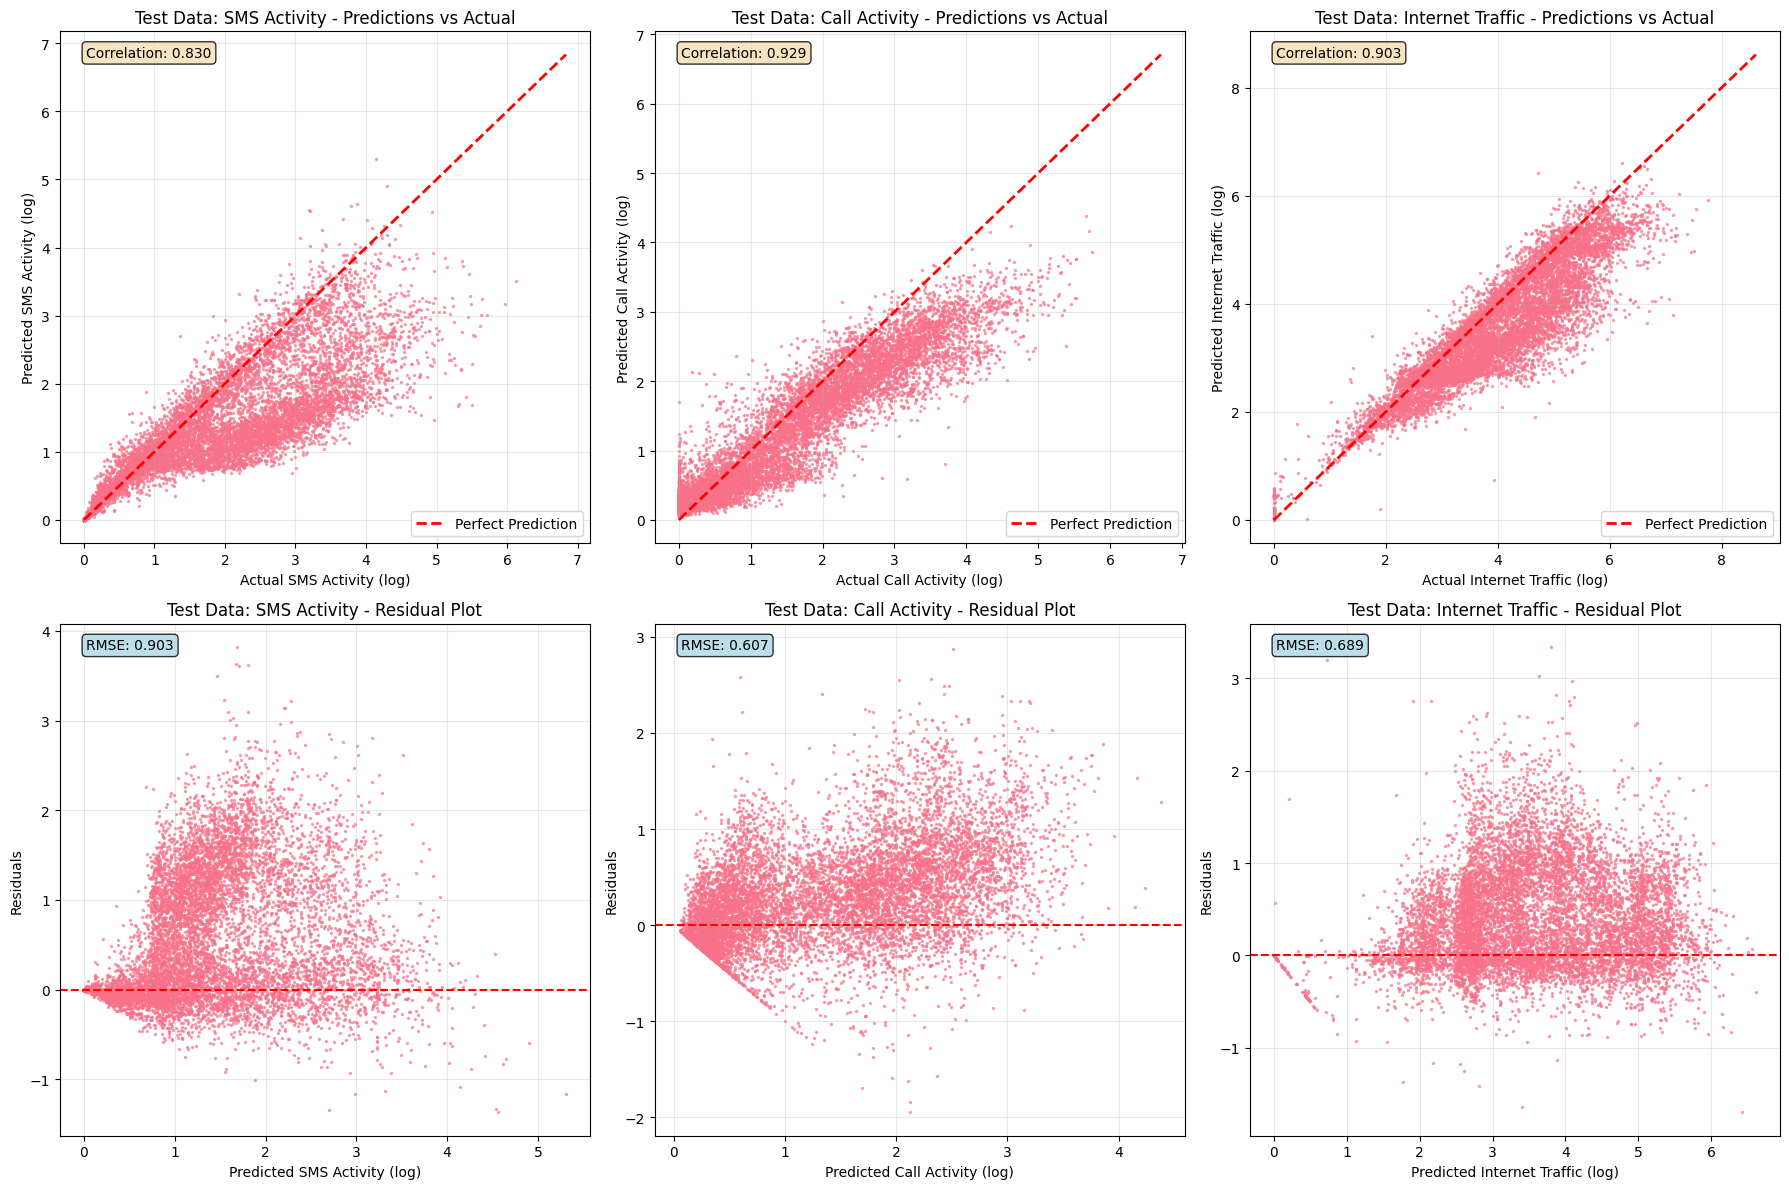

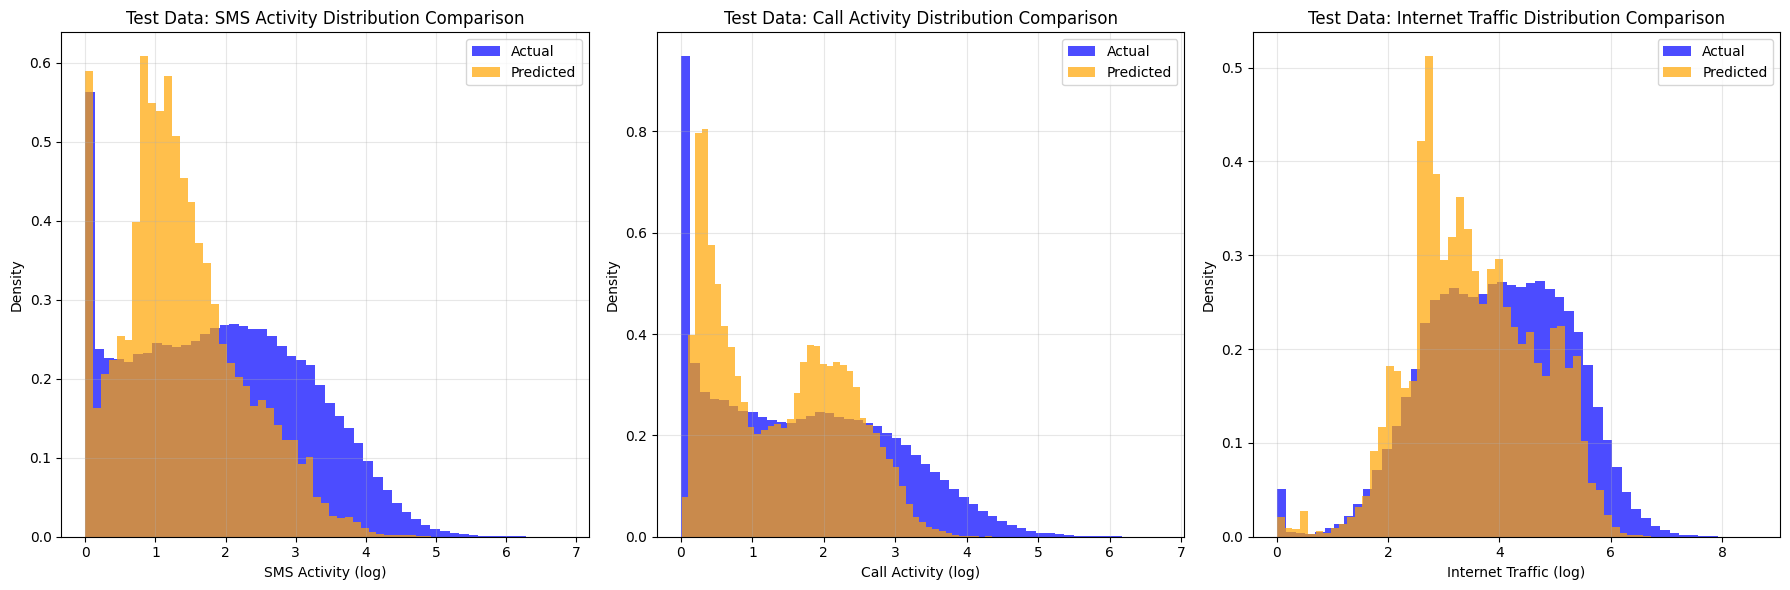

Test data visualization completed!


In [8]:
from sklearn.metrics import mean_squared_error, r2_score

# Load test data from testdata directory
test_dir = 'testdata'
test_files = []

# Walk through the test directory to find all files
for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.endswith(('.csv', '.parquet', '.json', '.xlsx')):
            test_files.append(os.path.join(root, file))

# Load and concatenate all test files
test_dfs = []
for file_path in test_files:
    try:
        if file_path.endswith('.csv'):
            temp_df = pd.read_csv(file_path)
            if len(test_dfs) >= 5:  # Only load first 1 files
                break
        
        test_dfs.append(temp_df)
        print(f"Loaded test file: {file_path}")
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

# Concatenate all test dataframes
if test_dfs:
    test_data = pd.concat(test_dfs, ignore_index=True)
    print(f"Successfully loaded {len(test_dfs)} test files into dataframe")
    print(f"Test data shape: {test_data.shape}")
    
    # Apply the same preprocessing as done to training data
    # Convert Time Interval column to datetime first
    test_data['Time Interval (GMT+1)'] = pd.to_datetime(test_data['Time Interval (GMT+1)'])
    
    # Split the Time Interval column into separate date and time components
    test_data['Date'] = test_data['Time Interval (GMT+1)'].dt.date
    test_data['Time_Numeric'] = test_data['Time Interval (GMT+1)'].dt.hour + test_data['Time Interval (GMT+1)'].dt.minute/60
    
    print("Test data time interval split completed!")
    
    # Apply the same transformations to test data
    test_transformed, _, _ = comprehensive_data_transformation(test_data)
    
    # Prepare test features
    X_test_new = test_transformed[final_features].fillna(0)
    
    # Scale test features using the same scaler
    X_test_new_scaled = scaler.transform(X_test_new)
    
    # Make predictions
    test_predictions = transformed_model.predict(X_test_new_scaled)
    
    # Create results dataframe
    test_results = pd.DataFrame({
        'SMS_activity_pred': test_predictions[:, 0],
        'Call_activity_pred': test_predictions[:, 1], 
        'Internet_activity_pred': test_predictions[:, 2]
    })
    
    # If test data has actual target values, calculate metrics
    if all(col in test_data.columns for col in target_vars):
        print("\nTest data contains target variables - calculating performance metrics:")
        
        # Transform test targets the same way
        test_targets = {}
        for target in target_vars:
            if target_transformations.get(target, target).endswith('_log'):
                test_targets[target] = np.log1p(test_data[target])
            else:
                test_targets[target] = test_data[target]
        
        # Calculate test metrics
        for i, target in enumerate(target_vars):
            actual = test_targets[target]
            predicted = test_predictions[:, i]
            
            mse = mean_squared_error(actual, predicted)
            rmse = np.sqrt(mse)
            r2 = r2_score(actual, predicted)
            
            print(f"\n{target} Test Performance:")
            print(f"  MSE: {mse:.4f}")
            print(f"  RMSE: {rmse:.4f}")
            print(f"  R2: {r2:.4f}")
    
    print(f"\nTest predictions completed! Shape: {test_results.shape}")
    print("First 5 predictions:")
    print(test_results.head())
    # Visualize actual vs predicted values for test data
    if all(col in test_data.columns for col in target_vars):
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        target_names = ['SMS Activity', 'Call Activity', 'Internet Traffic']
        
        for i, (target, target_name) in enumerate(zip(target_vars, target_names)):
            # Get actual and predicted values
            actual = test_targets[target]
            predicted = test_predictions[:, i]
            
            # Sample for visualization (use subset for better performance)
            sample_size = min(10000, len(actual))
            sample_idx = np.random.choice(len(actual), sample_size, replace=False)
            
            # Scatter plot of predictions vs actual
            ax1 = axes[0, i]
            ax1.scatter(actual.iloc[sample_idx], predicted[sample_idx], alpha=0.6, s=2)
            
            # Perfect prediction line
            min_val = min(actual.min(), predicted.min())
            max_val = max(actual.max(), predicted.max())
            ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
            
            ax1.set_xlabel(f'Actual {target_name} (log)')
            ax1.set_ylabel(f'Predicted {target_name} (log)')
            ax1.set_title(f'Test Data: {target_name} - Predictions vs Actual')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Add correlation coefficient
            correlation = np.corrcoef(actual, predicted)[0, 1]
            ax1.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                    transform=ax1.transAxes, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
            
            # Residuals plot
            ax2 = axes[1, i]
            residuals = actual.iloc[sample_idx] - predicted[sample_idx]
            ax2.scatter(predicted[sample_idx], residuals, alpha=0.6, s=2)
            ax2.axhline(y=0, color='r', linestyle='--')
            ax2.set_xlabel(f'Predicted {target_name} (log)')
            ax2.set_ylabel('Residuals')
            ax2.set_title(f'Test Data: {target_name} - Residual Plot')
            ax2.grid(True, alpha=0.3)
            
            # Add residual statistics
            rmse_val = np.sqrt(np.mean(residuals**2))
            ax2.text(0.05, 0.95, f'RMSE: {rmse_val:.3f}', 
                    transform=ax2.transAxes, bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        # Distribution comparison
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        for i, (target, target_name) in enumerate(zip(target_vars, target_names)):
            actual = test_targets[target]
            predicted = test_predictions[:, i]
            
            axes[i].hist(actual, bins=50, alpha=0.7, label='Actual', density=True, color='blue')
            axes[i].hist(predicted, bins=50, alpha=0.7, label='Predicted', density=True, color='orange')
            axes[i].set_xlabel(f'{target_name} (log)')
            axes[i].set_ylabel('Density')
            axes[i].set_title(f'Test Data: {target_name} Distribution Comparison')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("Test data visualization completed!")
    else:
        print("Test data visualization skipped - no actual target values available")
else:
    print("No test files found or loaded")